# PL波長の予測

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.cross_decomposition import PLSRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## データセット読み込み

In [ ]:
# 入力：読み込みたい記述子のタイプを選択
descriptor_type = 'mordred_3d'  # 'rdkit' or 'mordred_2d' or 'mordred_3d'

# ベースのデータ
dataset = pd.read_csv('data/material_data.csv', index_col=0)

# 条件に応じて記述子ファイルを読み込む
if descriptor_type == "rdkit":
    des = pd.read_csv("outputs/descriptors/descriptor_rdkit.csv", index_col=0)
elif descriptor_type == "mordred_2d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_2d.csv", index_col=0)
elif descriptor_type == "mordred_3d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_3d.csv", index_col=0)
else:
    raise ValueError(f"未知のdescriptor_type: {descriptor_type}")

# 結合
dataset_full = pd.concat([dataset.reset_index(), des.reset_index(drop=True)], axis=1)
dataset_full = dataset_full.set_index('Material')

# 確認
print(dataset.shape, des.shape, dataset_full.shape)

(251, 1481)

In [406]:
# PLに欠損値が入っている行を消して、学習データのみにする
dataset_train = dataset_full.dropna(subset='PL')
# SMILESとTypeも消しておく
dataset_train = dataset_train.drop(['SMILES', 'Type'], axis=1)

dataset_train.shape

(251, 1481)

In [407]:
# infをNaNに置き換え
dataset_train = dataset_train.replace(np.inf, np.nan).fillna(np.nan)
dataset_train = dataset_train.drop(dataset_train.columns[dataset_train.isnull().any()], axis=1)

# 標準偏差が0の記述を削除
dataset_train = dataset_train.drop(dataset_train.columns[dataset_train.std() == 0], axis=1)

# 学習データのstdが0の列を特定
zero_std_cols = dataset_train.columns[dataset_train.std() == 0]

# 学習・未知データから同じ列を削除
dataset_train = dataset_train.drop(columns=zero_std_cols)

print(dataset_train.shape)

(251, 1220)


In [408]:
# 欠損値の確認
dataset_train.isnull().sum().value_counts()

0    1220
Name: count, dtype: int64

In [409]:
# 目的変数と説明変数に分ける
y = dataset_train['PL']
X = dataset_train.drop('PL', axis=1)

# Hold-out
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234)

In [410]:
# 標準化
X_scaler = StandardScaler()
autoscaled_X_train = X_scaler.fit_transform(X_train)
autoscaled_X_val = X_scaler.transform(X_val)

y_scaler = StandardScaler()
autoscaled_y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
autoscaled_y_val = y_scaler.transform(y_val.values.reshape(-1,1))

# pandas形式に
autoscaled_X_train = pd.DataFrame(autoscaled_X_train, columns=X_train.columns, index=X_train.index)
autoscaled_X_val = pd.DataFrame(autoscaled_X_val, columns=X_val.columns, index=X_val.index)

autoscaled_y_train = pd.DataFrame(autoscaled_y_train, index=y_train.index, columns=["y"])
autoscaled_y_val = pd.DataFrame(autoscaled_y_val, index=y_val.index, columns=["y"])

# 標準化後、欠損値がないか再度確認
print(autoscaled_X_train.isnull().sum().value_counts())
print(autoscaled_X_val.isnull().sum().value_counts())

0    1219
Name: count, dtype: int64
0    1219
Name: count, dtype: int64


In [411]:
# 可視化の関数

def yyplot(train_df, test_df):
    # ===== 指標の計算 =====
    rmse_tr = np.sqrt(mean_squared_error(train_df['true'], train_df['pred']))
    r2_tr = r2_score(train_df['true'], train_df['pred'])
    mae_tr = mean_absolute_error(train_df['true'], train_df['pred'])

    rmse_te = np.sqrt(mean_squared_error(test_df['true'], test_df['pred']))
    r2_te = r2_score(test_df['true'], test_df['pred'])
    mae_te = mean_absolute_error(test_df['true'], test_df['pred'])

    # ===== グラフ作成 =====
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)

    # 散布図
    ax.scatter(train_df['true'], train_df['pred'], c='red', label='Train', alpha=0.6)
    ax.scatter(test_df['true'], test_df['pred'], c='blue', label='Val', alpha=0.6)

    # 理想線
    all_true = pd.concat([train_df['true'], test_df['true']])
    min_val = all_true.min()
    max_val = all_true.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # 軸ラベル
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')

    # 範囲調整
    margin = (max_val - min_val) * 0.05
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)

    # 評価値表示（右上）
    ax.text(0.05, 0.95, f'Train RMSE = {rmse_tr:.2f}\nTrain MAE  = {mae_tr:.2f}\nTrain R²    = {r2_tr:.2f}',
            transform=ax.transAxes, fontsize=11, color='red', verticalalignment='top')
    ax.text(0.05, 0.80, f'Val  RMSE = {rmse_te:.2f}\nVal  MAE  = {mae_te:.2f}\nVal  R²    = {r2_te:.2f}',
            transform=ax.transAxes, fontsize=11, color='blue', verticalalignment='top')

    # 凡例
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


## PLS

1 0.4286003341176675
2 0.6074052454035618
3 0.6477904162799426
4 0.6990440386112337
5 0.7290238522669947
6 0.7294947146784072
7 0.7101579982955799
8 0.6834131775593
9 0.6281919231706127
10 0.6009994619517297
11 0.5567216625228548
12 0.49574397917879176
13 0.5132998927513006
14 0.5624190706238814
15 0.5814763528411669
16 0.5896797685852786
17 0.5814378059549061
18 0.5719906706994833
19 0.5622435673829171
20 0.5591968694988263
21 0.558680341818268
22 0.5527586478404276
23 0.5560121335061307
24 0.5651853001808667
25 0.5788653662399011
26 0.5763608424750183
27 0.5660490444556573
28 0.5426448792384017
29 0.5279503814826679
30 0.5168966419587389


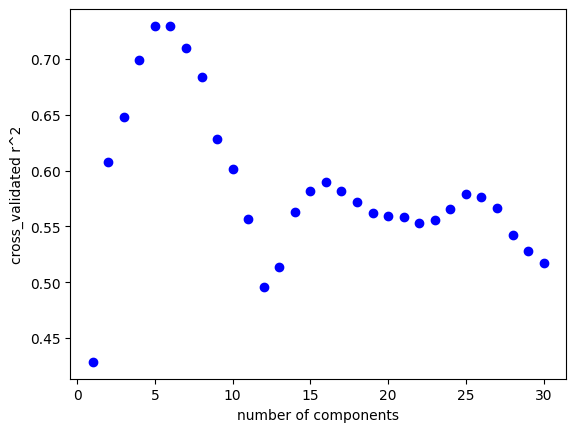

最適な主成分数 : 6


In [412]:
# CVによる成分数の最適化

# 使用する主成分の最大数。説明変数の数より小さい必要があります
max_number_of_principal_components = 30

# N-fold CV の N
fold_number = 5  

# 空のリストを用意
components = []
r2_in_cv_all = []

# reshapeしておく（Series → 1D ndarray）
y_train_1d = autoscaled_y_train.values.ravel()

for component in range(1, max_number_of_principal_components+1):
    # PLS
    model = PLSRegression(n_components=component)
    # CV
    estimated_y_cv = cross_val_predict(model, autoscaled_X_train, y_train_1d,
                                       cv=fold_number)
    estimated_y_cv = pd.DataFrame(estimated_y_cv)
    
    # r2を計算
    r2_in_cv = r2_score(y_train_1d, estimated_y_cv)
    
    # 成分数とr2を表示
    print(component, r2_in_cv)
    
    # r2とcomponentを追加
    components.append(component)
    r2_in_cv_all.append(r2_in_cv)

# 成分数毎のr^2をプロットし、CV後のr^2が最大の時を、最適成分数として抽出

plt.scatter(components, r2_in_cv_all, c='blue')
plt.xlabel('number of components')
plt.ylabel('cross_validated r^2')
plt.show()

# 最適な主成分数を取得
optimal_component_number = components[r2_in_cv_all.index(max(r2_in_cv_all))]

print('最適な主成分数 :', optimal_component_number)

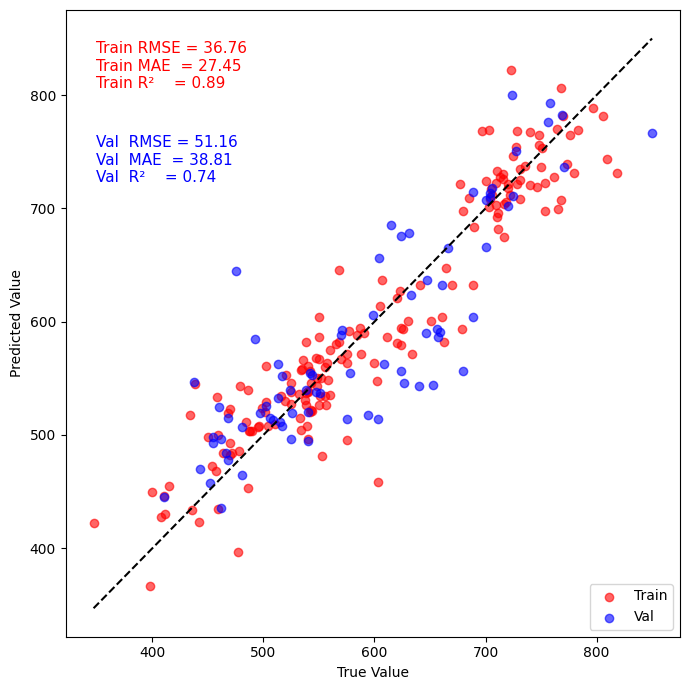

In [413]:
# 予測

# PLSモデルの構築
pls_model = PLSRegression(n_components=optimal_component_number)

# モデル学習
pls_model.fit(autoscaled_X_train, autoscaled_y_train)

# 予測
y_train_pred_scaled = pls_model.predict(autoscaled_X_train)
y_val_pred_scaled = pls_model.predict(autoscaled_X_val)

# 元のスケールに逆変換
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

# 可視化用データフレーム作成、yは2D配列から1Dベクトルに戻す
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)

- rdkitだとうまく機能しないが、mordred記述子だとうまくいく

## RandomForest

/opt/conda/envs/mol-regression-env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


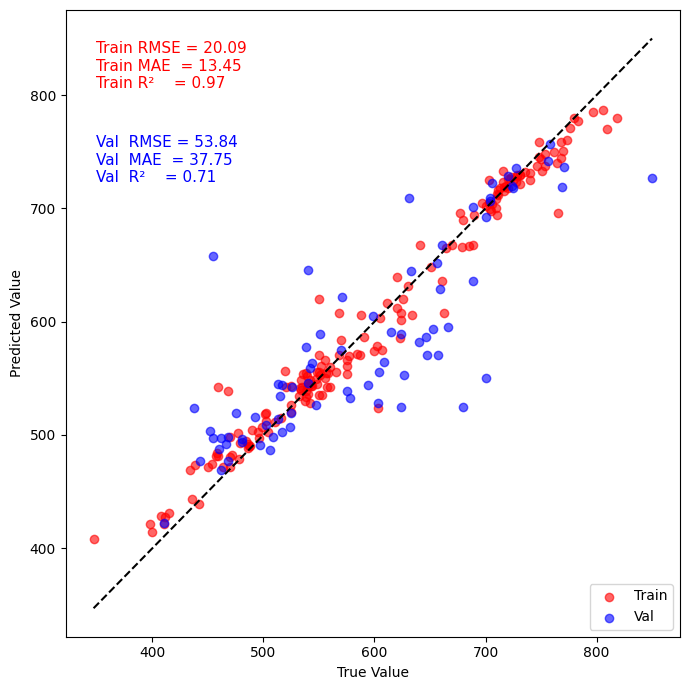

In [414]:
# デフォルト
model_rf = RandomForestRegressor(random_state=1234)

# モデル構築、予測
model_rf.fit(autoscaled_X_train, autoscaled_y_train)
y_train_pred_scaled = model_rf.predict(autoscaled_X_train)
y_val_pred_scaled = model_rf.predict(autoscaled_X_val)

# 元のスケールに逆変換（reshapeが必要）
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)

## RF+optuna

In [ ]:
def objective_rf(trial):
    # ハイパーパラメータのサンプリング
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # モデル定義
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=0,
        n_jobs=-1
    )

    # モデル学習
    model.fit(autoscaled_X_train, autoscaled_y_train)

    # 検証データでRMSEを評価
    y_pred_scaled = model.predict(autoscaled_X_val)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

In [416]:
# 学習
study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=30)

[I 2025-07-31 19:50:30,197] A new study created in memory with name: no-name-57a683ff-e8f2-4b40-a436-6b8665b84985


/opt/conda/envs/mol-regression-env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-31 19:50:30,937] Trial 0 finished with value: 55.00819992796594 and parameters: {'n_estimators': 122, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 55.00819992796594.
/opt/conda/envs/mol-regression-env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-31 19:50:31,851] Trial 1 finished with value: 55.52874461027042 and parameters: {'n_estimators': 241, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 8, '

In [417]:
# ハイパーパラメータ・スコアの確認
print("Best trial:")
trial = study.best_trial

print(f"  RMSE: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 51.6174
  Params:
    n_estimators: 228
    max_depth: 8
    min_samples_split: 4
    min_samples_leaf: 3
    max_features: sqrt


/opt/conda/envs/mol-regression-env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


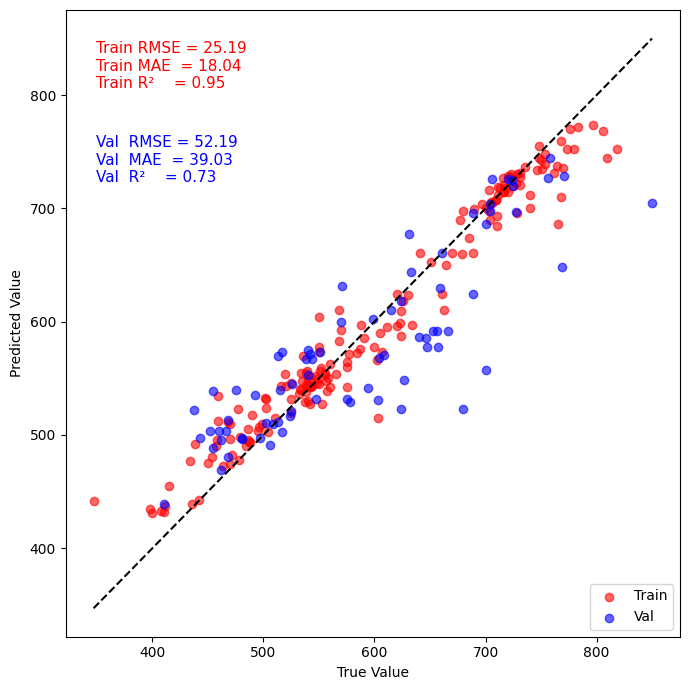

In [418]:
# 最良ハイパーパラメータで再学習
best_params = study.best_params
model_rf_optuna = RandomForestRegressor(**best_params, random_state=1234, n_jobs=-1)
model_rf_optuna.fit(autoscaled_X_train, autoscaled_y_train)

# 予測
y_train_pred_scaled = model_rf_optuna.predict(autoscaled_X_train)
y_val_pred_scaled = model_rf_optuna.predict(autoscaled_X_val)

# 元のスケールに逆変換（reshapeが必要）
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)

/tmp/ipykernel_3195/1094214051.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_rf['feature'][:10],


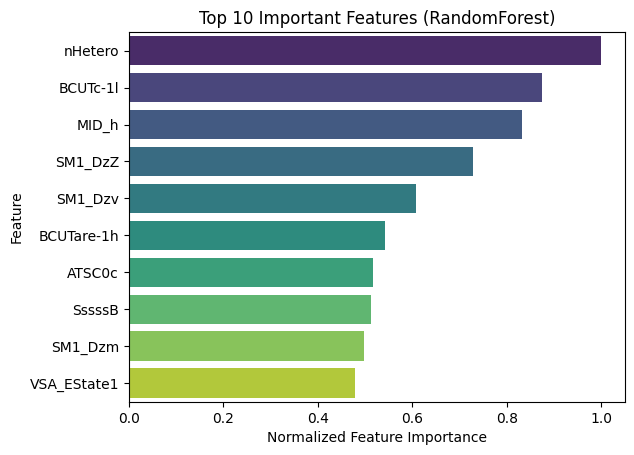

In [437]:
# 特徴量重要度を出す
feature_map_rf = pd.DataFrame([X_train.columns, model_rf_optuna.feature_importances_]).T
feature_map_rf.columns = ['feature', 'importances']

# 降順に
feature_map_rf = feature_map_rf.sort_values('importances', ascending=False)

# 規格化
feature_map_rf['importances'] = feature_map_rf['importances'] / feature_map_rf['importances'].max()

# 可視化
sns.barplot(y=feature_map_rf['feature'][:10],
            x=feature_map_rf['importances'][:10],
            palette='viridis')

plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (RandomForest)')
plt.show()

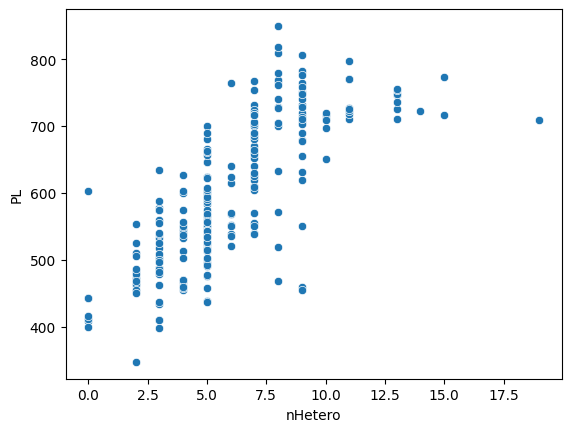

In [420]:
# 予測に役立った説明変数と目的関数の関係をplot

# 最も重要な特徴量の名前を取り出す（文字列）
top_feature = feature_map_rf['feature'].iloc[0]

sns.scatterplot(x=top_feature,
                y='PL',
                data=dataset_train)

plt.show()

## XGBoost

[0]	validation_0-rmse:0.83943
[1]	validation_0-rmse:0.66631
[2]	validation_0-rmse:0.55764
[3]	validation_0-rmse:0.51900
[4]	validation_0-rmse:0.49923
[5]	validation_0-rmse:0.48923
[6]	validation_0-rmse:0.48832
[7]	validation_0-rmse:0.48707
[8]	validation_0-rmse:0.48608
[9]	validation_0-rmse:0.48587
[10]	validation_0-rmse:0.48549
[11]	validation_0-rmse:0.48505
[12]	validation_0-rmse:0.48505
[13]	validation_0-rmse:0.48645
[14]	validation_0-rmse:0.48740
[15]	validation_0-rmse:0.48802
[16]	validation_0-rmse:0.48820
[17]	validation_0-rmse:0.48876
[18]	validation_0-rmse:0.48949
[19]	validation_0-rmse:0.49004
[20]	validation_0-rmse:0.49063
[21]	validation_0-rmse:0.49111
[22]	validation_0-rmse:0.49150
[23]	validation_0-rmse:0.49158
[24]	validation_0-rmse:0.49186
[25]	validation_0-rmse:0.49199
[26]	validation_0-rmse:0.49223
[27]	validation_0-rmse:0.49242
[28]	validation_0-rmse:0.49259
[29]	validation_0-rmse:0.49267
[30]	validation_0-rmse:0.49276
[31]	validation_0-rmse:0.49278
[32]	validation_0-

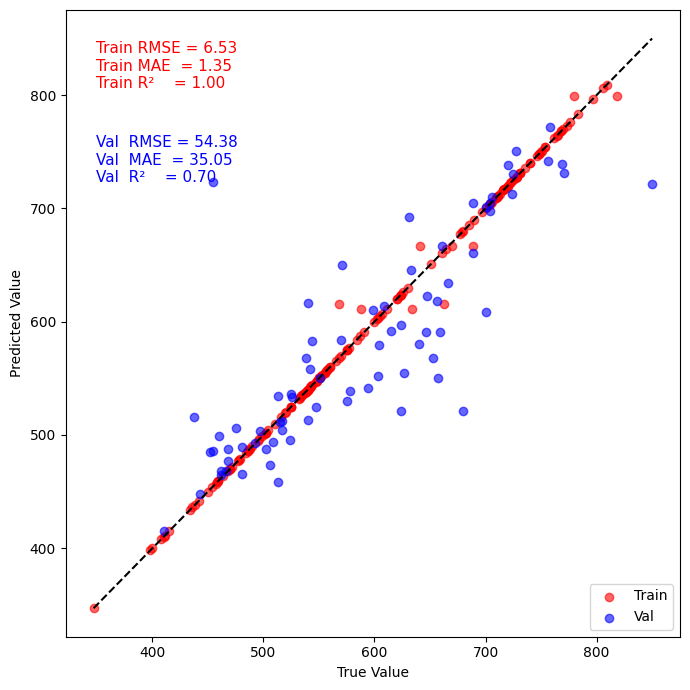

In [421]:
# デフォルトXGB
model_xgb = xgb.XGBRegressor(random_state=1234)

# モデル学習
model_xgb.fit(autoscaled_X_train, autoscaled_y_train, eval_set=[(autoscaled_X_val, autoscaled_y_val)])

# 予測
y_train_pred_scaled = model_xgb.predict(autoscaled_X_train)
y_val_pred_scaled = model_xgb.predict(autoscaled_X_val)

# 元のスケールに逆変換（reshapeが必要）
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)

## XGBoost+optuna

In [424]:
def objective_xgb(trial):
    # ハイパーパラメータのサンプリング
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'tree_method': 'hist',  # CPUで高速にする場合
    }

    model = xgb.XGBRegressor(**param)

    # 学習と予測
    model.fit(autoscaled_X_train, autoscaled_y_train, eval_set = [(autoscaled_X_val, autoscaled_y_val)], verbose=0)
    y_pred_scaled = model.predict(autoscaled_X_val)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # 検証データでRMSEを評価
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

In [425]:
# 学習
study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=50, timeout=600)  # 試行回数や時間は任意

[I 2025-07-31 19:54:32,766] A new study created in memory with name: no-name-323477aa-3e75-4762-8be4-0274a487a266
[I 2025-07-31 19:54:46,064] Trial 0 finished with value: 56.635269499438785 and parameters: {'n_estimators': 288, 'max_depth': 7, 'learning_rate': 0.005591647646046597, 'subsample': 0.8424342033253684, 'colsample_bytree': 0.7046538083581462, 'reg_alpha': 4.401969141111138e-06, 'reg_lambda': 0.44738826377604857}. Best is trial 0 with value: 56.635269499438785.
[I 2025-07-31 19:55:00,410] Trial 1 finished with value: 49.112357990733386 and parameters: {'n_estimators': 99, 'max_depth': 8, 'learning_rate': 0.06583668580743486, 'subsample': 0.5410181298555203, 'colsample_bytree': 0.6709639870081827, 'reg_alpha': 0.012287443820348038, 'reg_lambda': 0.0001753816316907862}. Best is trial 1 with value: 49.112357990733386.
[I 2025-07-31 19:55:19,458] Trial 2 finished with value: 50.84656911524346 and parameters: {'n_estimators': 251, 'max_depth': 9, 'learning_rate': 0.085154267739341

In [426]:
# ハイパーパラメータ・スコアの確認
print("Best trial:")
trial = study.best_trial

print(f"  RMSE: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 46.0846
  Params:
    n_estimators: 214
    max_depth: 4
    learning_rate: 0.15108228622415354
    subsample: 0.8061244300422435
    colsample_bytree: 0.7187002909054254
    reg_alpha: 1.8870429523578984e-06
    reg_lambda: 1.9159219106546759


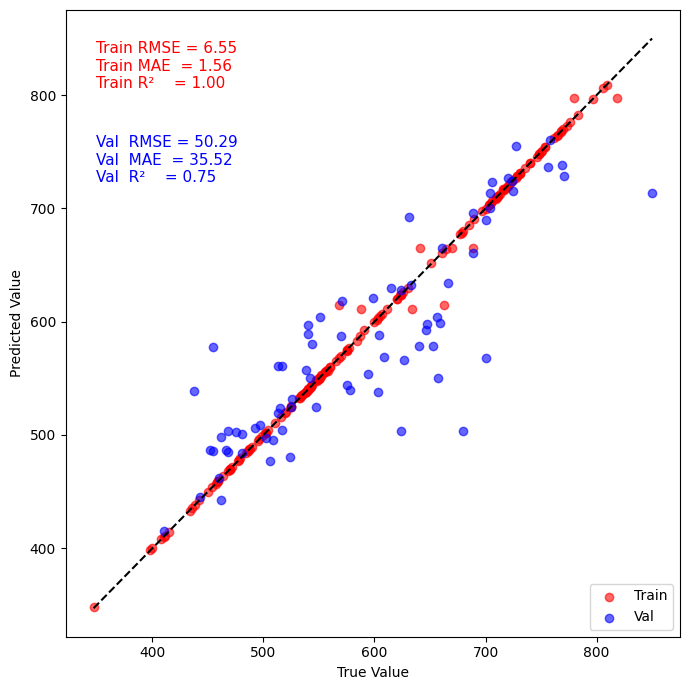

In [427]:
# 再学習
best_params = trial.params
model_xgb_optuna = xgb.XGBRegressor(**best_params)
model_xgb_optuna.fit(autoscaled_X_train, autoscaled_y_train, eval_set=[(autoscaled_X_val, autoscaled_y_val)], verbose=0)

# 予測
y_train_pred_scaled = model_xgb_optuna.predict(autoscaled_X_train)
y_val_pred_scaled = model_xgb_optuna.predict(autoscaled_X_val)

# 元のスケールに逆変換（reshapeが必要）
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)

/tmp/ipykernel_3195/4048397037.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_xgb['feature'][:10],


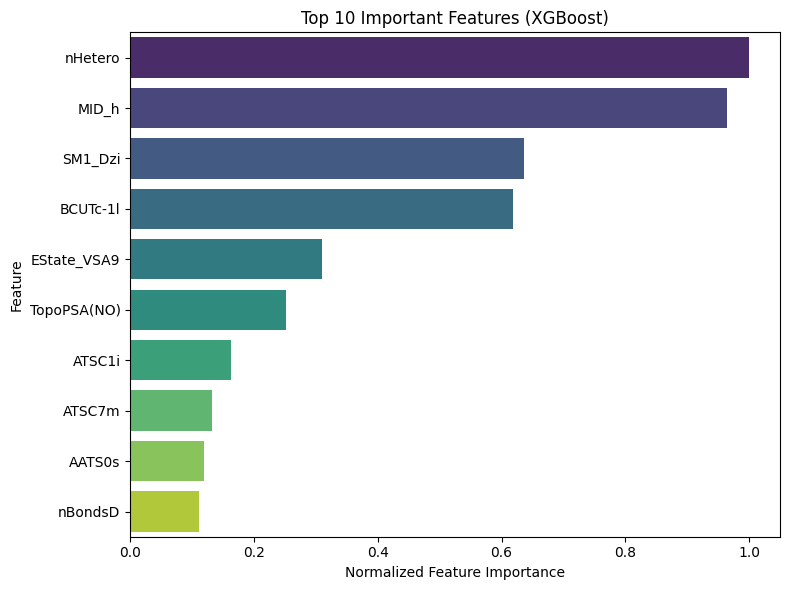

In [428]:
# 特徴量重要度を取得
feature_map_xgb = pd.DataFrame([X_train.columns, model_xgb_optuna.feature_importances_]).T
feature_map_xgb.columns = ['feature', 'importances']

# 降順に並べ替え
feature_map_xgb = feature_map_xgb.sort_values('importances', ascending=False)

# 規格化（最大値で割る）
feature_map_xgb['importances'] = feature_map_xgb['importances'] / feature_map_xgb['importances'].max()

# 上位10個の特徴量を可視化
plt.figure(figsize=(8, 6))
sns.barplot(y=feature_map_xgb['feature'][:10],
            x=feature_map_xgb['importances'][:10],
            palette='viridis')
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (XGBoost)')
plt.tight_layout()
plt.show()

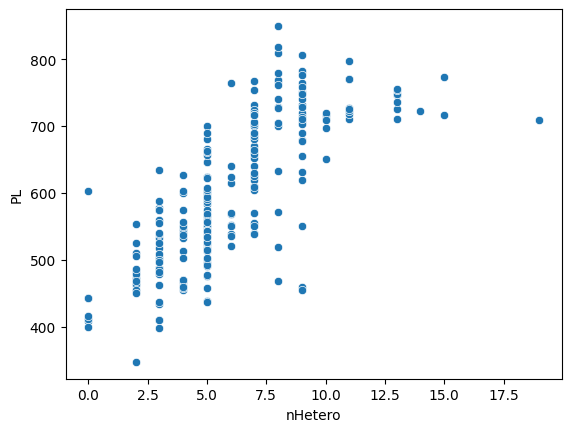

In [429]:
# 予測に役立った説明変数と目的関数の関係をplot

# 最も重要な特徴量の名前を取り出す（文字列）
top_feature = feature_map_xgb['feature'].iloc[0]

sns.scatterplot(x=top_feature,
                y='PL',
                data=dataset_train)

plt.show()

## LightGBM

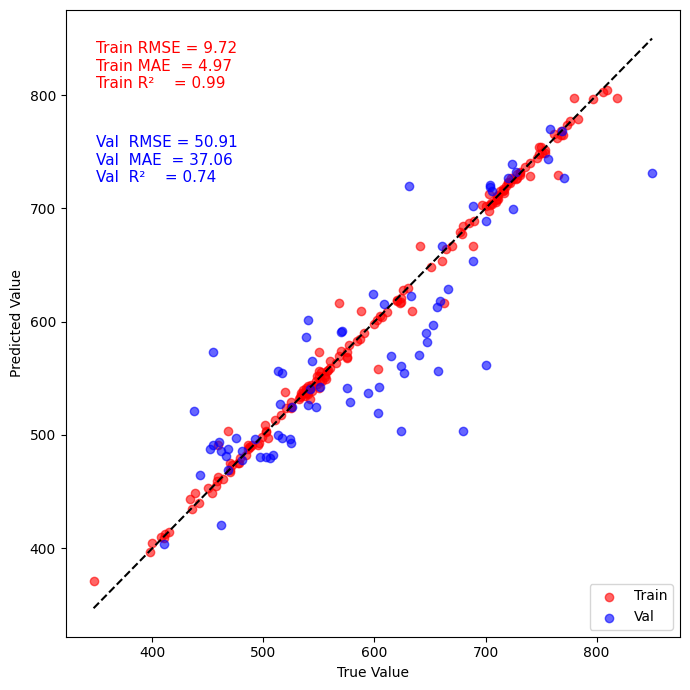

In [430]:
# デフォルト
model_lgb = lgb.LGBMRegressor(random_state=1234)

# モデル学習
model_lgb.fit(autoscaled_X_train, autoscaled_y_train, eval_set = [(autoscaled_X_val, autoscaled_y_val)])

# 予測
y_train_pred_scaled = model_lgb.predict(autoscaled_X_train)
y_val_pred_scaled = model_lgb.predict(autoscaled_X_val)

# 元のスケールに逆変換（reshapeが必要）
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)

## LightGBM+optuna

In [438]:
def objective_lgb(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',  # LightGBMが内部で使う評価指標
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
        'min_child_samples' :trial.suggest_int('min_child_samples', 1, 10),
        'random_state': 42,
        'verbosity': -1,
    }

    model = lgb.LGBMRegressor(**param)

    # 学習&予測
    model.fit(autoscaled_X_train, autoscaled_y_train, eval_set=[(autoscaled_X_val, autoscaled_y_val)])
    y_pred_scaled = model.predict(autoscaled_X_val)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # 汎化性能算出
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [439]:
# 最適化
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgb, n_trials=50, timeout=600)  # 50試行 or 600秒

# 結果表示
print("Best trial:")
print(f"  RMSE: {study.best_trial.value:.4f}")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-31 20:31:33,578] A new study created in memory with name: no-name-56d18881-efdb-49c2-bd8a-8bc7de2157c1
[I 2025-07-31 20:31:34,421] Trial 0 finished with value: 54.16994175090395 and parameters: {'n_estimators': 169, 'learning_rate': 0.023058766509113, 'max_depth': 6, 'num_leaves': 23, 'subsample': 0.6815653713032466, 'colsample_bytree': 0.7730329183769227, 'reg_alpha': 3.420497236677358e-05, 'reg_lambda': 3.931151720673857e-08, 'min_data_in_leaf': 3, 'min_child_samples': 3}. Best is trial 0 with value: 54.16994175090395.
[I 2025-07-31 20:31:34,773] Trial 1 finished with value: 49.201923450323086 and parameters: {'n_estimators': 206, 'learning_rate': 0.1786360141498596, 'max_depth': 4, 'num_leaves': 28, 'subsample': 0.9177447238279749, 'colsample_bytree': 0.7066178348301997, 'reg_alpha': 0.015442718794007868, 'reg_lambda': 6.809528026181766e-07, 'min_data_in_leaf': 6, 'min_child_samples': 5}. Best is trial 1 with value: 49.201923450323086.
[I 2025-07-31 20:31:35,068] Trial 2 

Best trial:
  RMSE: 47.6359
    n_estimators: 281
    learning_rate: 0.08481241820280185
    max_depth: 3
    num_leaves: 55
    subsample: 0.7051369888415676
    colsample_bytree: 0.6189382024481481
    reg_alpha: 6.386476273078106e-06
    reg_lambda: 3.7597161363457143e-08
    min_data_in_leaf: 6
    min_child_samples: 9


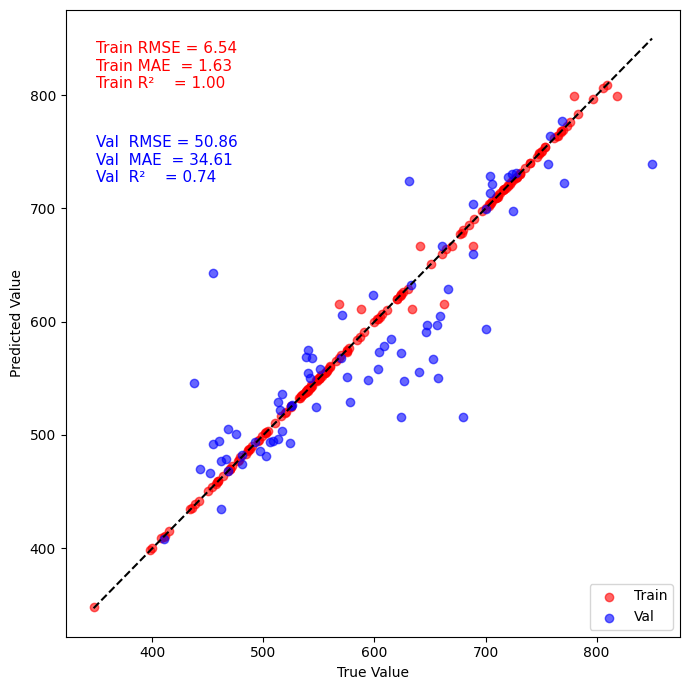

In [440]:
# モデル再構築
best_params = study.best_trial.params

model_lgb_optuna = lgb.LGBMRegressor(**best_params)
model_lgb_optuna.fit(autoscaled_X_train, autoscaled_y_train)

# 予測
y_train_pred_scaled = model_lgb_optuna.predict(autoscaled_X_train)
y_val_pred_scaled = model_lgb_optuna.predict(autoscaled_X_val)

# 元のスケールに逆変換（reshapeが必要）
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)


/tmp/ipykernel_3195/4082038596.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_lgb['feature'][:10],


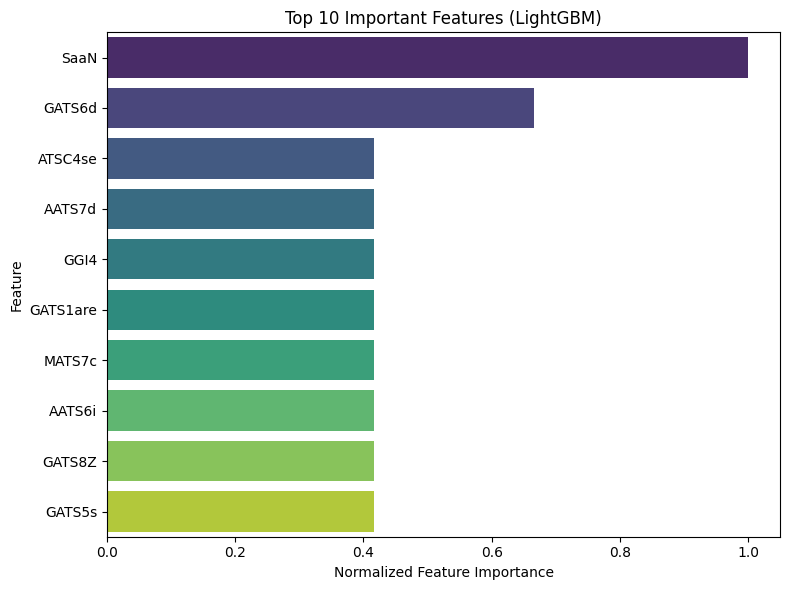

In [436]:
# 特徴量重要度の取得
feature_map_lgb = pd.DataFrame({
    'feature': X_train.columns,
    'importances': model_lgb_optuna.feature_importances_
})

# 降順に並べ替え
feature_map_lgb = feature_map_lgb.sort_values('importances', ascending=False)

# 規格化（最大値で割る）
feature_map_lgb['importances'] = feature_map_lgb['importances'] / feature_map_lgb['importances'].max()

# 上位10個の特徴量を可視化
plt.figure(figsize=(8, 6))
sns.barplot(y=feature_map_lgb['feature'][:10],
            x=feature_map_lgb['importances'][:10],
            palette='viridis')
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (LightGBM)')
plt.tight_layout()
plt.show()

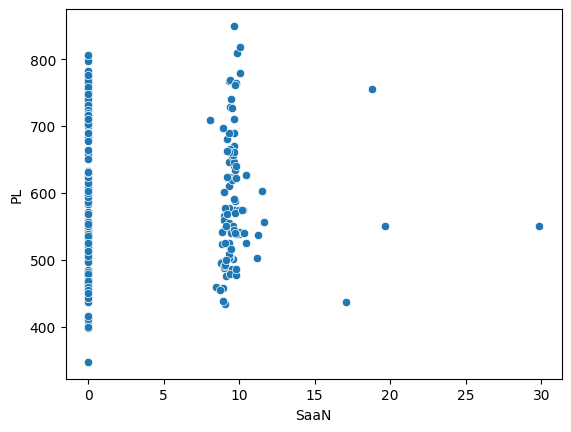

In [441]:
# 予測に役立った説明変数と目的関数の関係をplot

# 最も重要な特徴量の名前を取り出す（文字列）
top_feature = feature_map_lgb['feature'].iloc[0]

sns.scatterplot(x=top_feature,
                y='PL',
                data=dataset_train)

plt.show()

## NN

In [442]:
# GPU set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [443]:
# NN定義
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [444]:
# モデル構築
model_nn = MLPRegressor(input_dim=X.shape[1]).to(device)
# 損失関数
criterion = nn.MSELoss()
# 最適化関数
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-4)

In [445]:
# データセット定義
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Datasetに渡す（.valuesでnumpy化）
train_ds = RegressionDataset(autoscaled_X_train.values, autoscaled_y_train.values)
val_ds = RegressionDataset(autoscaled_X_val.values, autoscaled_y_val.values)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)

In [446]:
# 学習loop
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# 評価
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

Epoch   0 | Train Loss: 0.9001 | Val Loss: 0.7760
Epoch   1 | Train Loss: 0.7058 | Val Loss: 0.6723
Epoch   2 | Train Loss: 0.6057 | Val Loss: 0.6055
Epoch   3 | Train Loss: 0.4966 | Val Loss: 0.5416
Epoch   4 | Train Loss: 0.4949 | Val Loss: 0.5052
Epoch   5 | Train Loss: 0.5069 | Val Loss: 0.4616
Epoch   6 | Train Loss: 0.4129 | Val Loss: 0.4365
Epoch   7 | Train Loss: 0.4541 | Val Loss: 0.4166
Epoch   8 | Train Loss: 0.3483 | Val Loss: 0.4107
Epoch   9 | Train Loss: 0.3427 | Val Loss: 0.4143
Epoch  10 | Train Loss: 0.3287 | Val Loss: 0.4053
Epoch  11 | Train Loss: 0.3305 | Val Loss: 0.4067
Epoch  12 | Train Loss: 0.2702 | Val Loss: 0.3860
Epoch  13 | Train Loss: 0.2957 | Val Loss: 0.3867
Epoch  14 | Train Loss: 0.2591 | Val Loss: 0.3820
Epoch  15 | Train Loss: 0.2783 | Val Loss: 0.3754
Epoch  16 | Train Loss: 0.2823 | Val Loss: 0.3515
Epoch  17 | Train Loss: 0.2926 | Val Loss: 0.3250
Epoch  18 | Train Loss: 0.2848 | Val Loss: 0.3116
Epoch  19 | Train Loss: 0.3141 | Val Loss: 0.3100


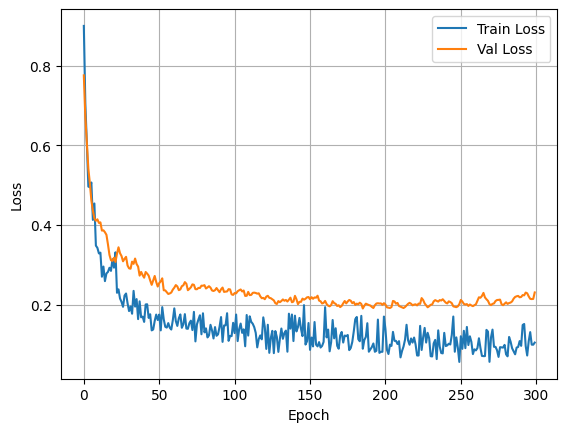

In [447]:
# 学習実行
n_epochs = 300

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train(model_nn, train_dl, optimizer, criterion, device)
    val_loss = evaluate(model_nn, val_dl, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 学習推移の可視化
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


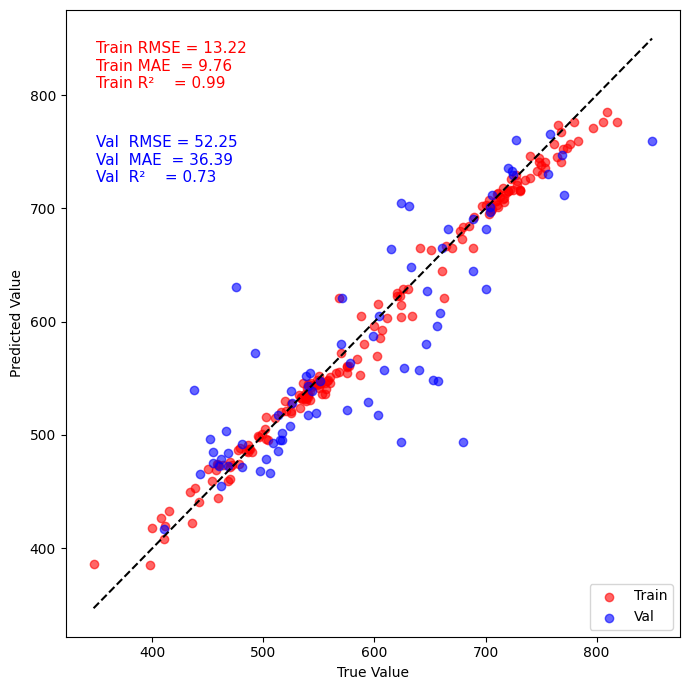

In [448]:
# 推論関数
def predict(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            preds.append(y_pred)
    return np.vstack(preds)

# 推論用（shuffleなし）DataLoaderを用意、train_dl を shuffle=True で作って学習したあと、その同じ train_dl で推論してしまうと、y_train と pred の順序が一致しなくなって、結果がズレます。
train_dl_eval = DataLoader(train_ds, batch_size=32, shuffle=False)
val_dl_eval = DataLoader(val_ds, batch_size=32, shuffle=False)

# 推論
y_train_pred_scaled = predict(model_nn, train_dl_eval, device) 
y_val_pred_scaled = predict(model_nn, val_dl_eval, device)

# 逆変換
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

# 可視化用データフレーム作成
train_df = pd.DataFrame({
    'true': y_train.reset_index(drop=True),
    'pred': y_train_pred.flatten()
})
val_df = pd.DataFrame({
    'true': y_val.reset_index(drop=True),
    'pred': y_val_pred.flatten()
})

# 可視化
yyplot(train_df, val_df)


## NN+optuna

In [ ]:
import optuna
import torch.nn.functional as F

def define_model(trial, input_dim):
    layers = []
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_dim = trial.suggest_int("hidden_dim", 64, 1024)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    activation_name = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])

    in_dim = input_dim
    for i in range(n_layers):
        layers.append(nn.Linear(in_dim, hidden_dim))

        # 活性化関数の前に入れる
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_dim))

        if activation_name == "relu":
            layers.append(nn.ReLU())
        else:
            layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(dropout_rate))
        in_dim = hidden_dim

    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

def objective_nn(trial):
    # データ準備（定義済み）
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    model = define_model(trial, input_dim=X.shape[1]).to(device)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    # 学習ループ
    for epoch in range(30):
        train(model, train_dl, optimizer, criterion, device)

    # 検証
    val_loss = evaluate(model, val_dl, criterion, device)  # 前に定義した `evaluate` 関数を使う
    return val_loss

In [450]:
# 学習
study = optuna.create_study(direction="minimize")
study.optimize(objective_nn, n_trials=50)
print("Best trial:", study.best_trial.params)

[I 2025-07-31 20:42:55,135] A new study created in memory with name: no-name-a86d1ff5-d02a-4f18-9deb-871cb63bd2fe
[I 2025-07-31 20:42:55,420] Trial 0 finished with value: 0.8332674503326416 and parameters: {'batch_size': 128, 'n_layers': 3, 'hidden_dim': 260, 'dropout_rate': 0.41308886571459824, 'activation': 'relu', 'use_batchnorm': False, 'lr': 0.0005613205131853447, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8332674503326416.
[I 2025-07-31 20:42:55,881] Trial 1 finished with value: 0.7762967944145203 and parameters: {'batch_size': 64, 'n_layers': 5, 'hidden_dim': 214, 'dropout_rate': 0.0874673224997859, 'activation': 'relu', 'use_batchnorm': False, 'lr': 2.3369339378000545e-05, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7762967944145203.
[I 2025-07-31 20:42:56,208] Trial 2 finished with value: 0.19037289917469025 and parameters: {'batch_size': 128, 'n_layers': 2, 'hidden_dim': 291, 'dropout_rate': 0.009947616379219426, 'activation': 'leaky_relu', 'use_batchnorm': Tru

Best trial: {'batch_size': 128, 'n_layers': 4, 'hidden_dim': 301, 'dropout_rate': 0.04775337109958868, 'activation': 'leaky_relu', 'use_batchnorm': True, 'lr': 0.0022681652345371193, 'optimizer': 'Adam'}


In [451]:
# 結果表示
print("Best trial:")
print(f"  RMSE: {study.best_trial.value:.4f}")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 0.1657
    batch_size: 128
    n_layers: 4
    hidden_dim: 301
    dropout_rate: 0.04775337109958868
    activation: leaky_relu
    use_batchnorm: True
    lr: 0.0022681652345371193
    optimizer: Adam


In [452]:
study.best_params

{'batch_size': 128,
 'n_layers': 4,
 'hidden_dim': 301,
 'dropout_rate': 0.04775337109958868,
 'activation': 'leaky_relu',
 'use_batchnorm': True,
 'lr': 0.0022681652345371193,
 'optimizer': 'Adam'}

In [454]:
# モデル定義
class TunedMLP(nn.Module):
    def __init__(self, input_dim):
        super(TunedMLP, self).__init__()
        layers = []
        in_dim = input_dim
        hidden_dim = study.best_params['hidden_dim']
        n_layers = study.best_params['n_layers']
        dropout_rate = study.best_params['dropout_rate']
        activation = nn.LeakyReLU() if study.best_params['activation'] == "leaky_relu" else nn.ReLU()
        use_batchnorm = study.best_params.get('use_batchnorm', False)

        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [467]:
# DataLoader（batch_sizeも反映）
train_dl = DataLoader(train_ds, batch_size=study.best_params['batch_size'], shuffle=True)
val_dl = DataLoader(val_ds, batch_size=study.best_params['batch_size'])

# モデル・損失関数・最適化手法
model_nn = TunedMLP(input_dim=X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=study.best_params['lr'])

# 学習
train_losses, val_losses = [], []
for epoch in range(1, 100):
    train_loss = train(model_nn, train_dl, optimizer, criterion, device)
    val_loss = evaluate(model_nn, val_dl, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 001 | Train Loss: 0.8054 | Val Loss: 0.6497
Epoch 002 | Train Loss: 1.2455 | Val Loss: 0.6494
Epoch 003 | Train Loss: 0.3626 | Val Loss: 0.5647
Epoch 004 | Train Loss: 0.2447 | Val Loss: 0.4625
Epoch 005 | Train Loss: 0.1487 | Val Loss: 0.4006
Epoch 006 | Train Loss: 0.1639 | Val Loss: 0.2739
Epoch 007 | Train Loss: 0.1574 | Val Loss: 0.2819
Epoch 008 | Train Loss: 0.1330 | Val Loss: 0.3203
Epoch 009 | Train Loss: 0.1453 | Val Loss: 0.2632
Epoch 010 | Train Loss: 0.1515 | Val Loss: 0.2394
Epoch 011 | Train Loss: 0.1020 | Val Loss: 0.2643
Epoch 012 | Train Loss: 0.0814 | Val Loss: 0.2823
Epoch 013 | Train Loss: 0.0925 | Val Loss: 0.2199
Epoch 014 | Train Loss: 0.0970 | Val Loss: 0.1939
Epoch 015 | Train Loss: 0.0690 | Val Loss: 0.1921
Epoch 016 | Train Loss: 0.0714 | Val Loss: 0.2006
Epoch 017 | Train Loss: 0.0836 | Val Loss: 0.2087
Epoch 018 | Train Loss: 0.0627 | Val Loss: 0.1980
Epoch 019 | Train Loss: 0.0630 | Val Loss: 0.1951
Epoch 020 | Train Loss: 0.1006 | Val Loss: 0.1996


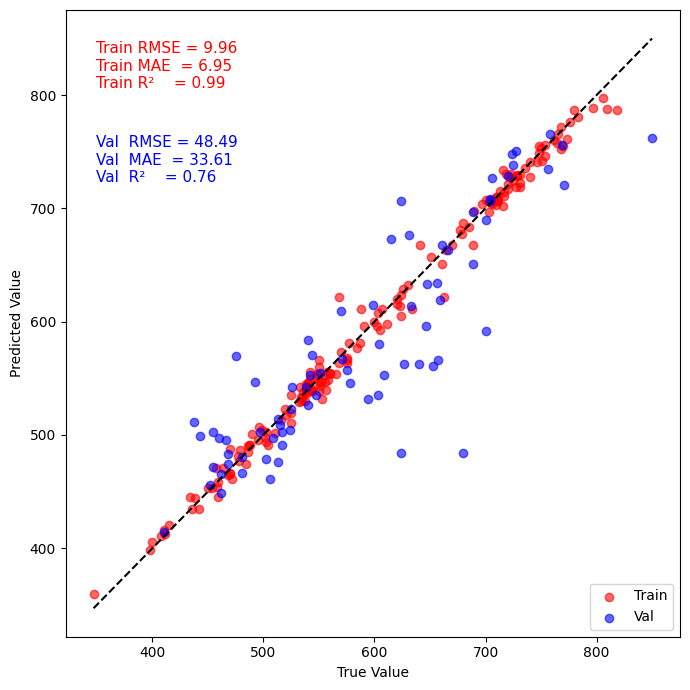

In [468]:
# 推論用DataLoader（shuffle=Falseで固定）
train_dl = DataLoader(train_ds, batch_size=study.best_params['batch_size'], shuffle=False)
val_dl = DataLoader(val_ds, batch_size=study.best_params['batch_size'], shuffle=False)

# 推論 & 逆変換
y_train_pred = y_scaler.inverse_transform(predict(model_nn, train_dl_eval, device))
y_val_pred = y_scaler.inverse_transform(predict(model_nn, val_dl_eval, device))

# 可視化データ作成
train_df = pd.DataFrame({'true': y_train.reset_index(drop=True), 'pred': y_train_pred.flatten()})
val_df = pd.DataFrame({'true': y_val.reset_index(drop=True), 'pred': y_val_pred.flatten()})

# 可視化
yyplot(train_df, val_df)
